In [1]:
#!pip3 install opencv-python
#!pip install pafy -U
#!pip install youtube_dl

In [2]:
#!pip install ipydagred3
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#

In [3]:
# fix dislike count problem
#!pip uninstall -y pafy
#!pip install git+https://github.com/Cupcakus/pafy

In [4]:
#!pip install ipynb

In [5]:
#!ls -l /home/jovyan/work/images
#!touch /home/jovyan/work/images/test

In [6]:
#!jupyter nbconvert --to python video_actions_v2.ipynb
#!jupyter nbconvert --to python video_download.ipynb
#!jupyter nbconvert --to python video_download_file.ipynb

In [7]:
from ipynb.fs.full.video_actions_v2 import *
#from ipynb.fs.full.coral_actions import *
from ipynb.fs.full.interact_with_app import *

# Coral Actions

## PoseEngineAction

In [8]:
import random
from PIL import Image
from PIL import ImageDraw

from pycoral.utils import edgetpu
from PIL import Image
from tflite_runtime.interpreter import load_delegate
from tflite_runtime.interpreter import Interpreter

import collections
import enum
import math
import numpy as np
import os
import platform
import sys
import time

from projectposenet.pose_engine import PoseEngine

colors = [(255,0,0,255) ,(0,255,0,255) ,(0,0,255,255),(255,255,0,255) ,(0,255,255,255) ,(255,255,255,255), \
         (125,0,0,255) ,(125,255,0,255) ,(125,0,255,255),(125,255,0,255) ,(125,255,255,255) ,(125,255,255,255)]

EDGES = (
    ('nose', 'left eye'),
    ('nose', 'right eye'),
    ('nose', 'left ear'),
    ('nose', 'right ear'),
    ('left ear', 'left eye'),
    ('right ear', 'right eye'),
    ('left eye', 'right eye'),
    ('left shoulder', 'right shoulder'),
    ('left shoulder', 'left elbow'),
    ('left shoulder', 'left hip'),
    ('right shoulder', 'right elbow'),
    ('right shoulder', 'right hip'),
    ('left elbow', 'left wrist'),
    ('right elbow', 'right wrist'),
    ('left hip', 'right hip'),
    ('left hip', 'left knee'),
    ('right hip', 'right knee'),
    ('left knee', 'left ankle'),
    ('right knee', 'right ankle'),
)

# 481x641
class PoseEngineAction(BaseAction):
    def __init__(self):
        self.engine = PoseEngine('projectposenet/models/mobilenet/posenet_mobilenet_v1_075_481_641_quant_decoder_edgetpu.tflite')
        self.result = None
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
            image = self._get_image(kwargs['image'])
            poses, inference_time = self.engine.DetectPosesInImage(image)
            self.result = {'poses':poses, 'inference_time':inference_time,'image':kwargs['image']}
            return self.result

In [9]:
from PIL import Image, ImageDraw, ImageFont
import random
colors = [(255,0,0,255) ,(0,255,0,255) ,(0,0,255,255),(255,255,0,255) ,(0,255,255,255) ,(255,255,255,255), \
         (125,0,0,255) ,(125,255,0,255) ,(125,0,255,255),(125,255,0,255) ,(125,255,255,255) ,(125,255,255,255)]

class Pose:
    def __init__(self, pose, minScoreKeypoint=-1):
        self.pose = pose
        self.xys = self.get_xys(pose, minScoreKeypoint)
        
    def get_xys(self,pose, min_score=-1):
        xys = {}
        for label, keypoint in pose.keypoints.items():
            score =  float(keypoint.score)
            if score < min_score: continue
            kp_y = int((keypoint.point.y) )
            kp_x = int((keypoint.point.x) )
            xys[label] = (kp_x, kp_y, score)
        return xys            
        
    def addPointsText(self,img,keys,color,r,fontsize):
        for key in keys:
            if key in self.xys:
                x = self.xys[key][0]
                y = self.xys[key][1]
                img.drawPoint( x,y,r,color)
                img.drawText(str(key), x,y,fontsize, color=color)
                
    def addSkeleton(self,img,EDGES,color='red',width=1):
        for a, b in EDGES:
            if a not in self.xys or b not in self.xys: continue
            ax, ay = self.xys[a][0],self.xys[a][1]
            bx, by = self.xys[b][0],self.xys[b][1]
            img.drawLine(ax,ay,bx,by,color=color,width=width)
                
    def printPose(self,mninScorePose=-0.1, minScoreKeypoint=-0.1):
        #if self.pose.score < mninScorePose : continue
        print('\nPose Score: ', self.pose.score)
        for label, keypoint in self.pose.keypoints.items():
            if keypoint.score < minScoreKeypoint : continue
            print(' %-20s x=%-4d y=%-4d score=%.2f' %
                (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))


## DrawPoseAction

In [10]:

                  
class DrawPoseAction(BaseAction):
    def __init__(self):
        self.result = None
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys() and 'poses' in kwargs.keys() :
            image = kwargs['image']
            poses = kwargs['poses']
            self.drawPosePoints(image,poses,EDGES) 
            self.addSkeletons(image,poses,EDGES)
            self.result = {'image':image}
            return self.result
        else:
            return kwargs                
        
    def drawPoint(self,image,x,y,r,rgba):
        draw = ImageDraw.Draw(image)
        leftUpPoint = (x-r, y-r)
        rightDownPoint = (x+r, y+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, fill=rgba)

    def drawPosePoints(self,image,poses,EDGES):    
        for pose in poses:
            #if pose.score < 0.4: continue
            rgba =  random.choice(colors)     
            #print('\nPose Score: ', pose.score)
            xys = {}
            minScoreKeypoint = 0.0
            for label, keypoint in pose.keypoints.items():
                if keypoint.score < minScoreKeypoint : continue
                #print(keypoint.point)
                #drawPoint(image,keypoint.yx[1], keypoint.yx[0],2,rgba)
                self.drawPoint(image,keypoint.point.x,keypoint.point.y,2,rgba)
                #kp_y = int((keypoint.yx[0] ) )
                #kp_x = int((keypoint.yx[1] ) )
                kp_y = int( keypoint.point.y)
                kp_x = int( keypoint.point.x)

                xys[label] = (kp_x, kp_y)
                #print(' %-20s x=%-4d y=%-4d score=%.1f' %
                #      (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))
            #print(xys)

            for a, b in EDGES:
                if a not in xys or b not in xys: continue
                ax, ay = xys[a]
                bx, by = xys[b]
                #dwg.add(dwg.line(start=(ax, ay), end=(bx, by), stroke=color, stroke_width=2))
                draw = ImageDraw.Draw(image)
                draw.line((ax,ay,bx,by), fill=128, width=3)
                #print (ax,ay,bx,b)    
                
    def addSkeletons(self,image,poses,EDGES):
        for pose in poses:   
            _pose = Pose(pose)
            _pose.addSkeleton(image,EDGES,color='red',width=1)

## ObjectsInterpreterAction

In [11]:
import time

from PIL import Image
from PIL import ImageDraw

from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file
from pycoral.utils.edgetpu import make_interpreter

class ObjectsInterpreterAction(BaseAction):
    def __init__(self, score_threshold=0.2):
        self.score_threshold = score_threshold 
        self.filter = []
        self.result = None
        # https://github.com/google-coral/test_data
        # https://coral.ai/models/object-detection/
        self.labels = read_label_file('/home/pi/jupyter/coral/pycoral/test_data/coco_labels.txt')
        self.interpreter = make_interpreter('/home/pi/jupyter/coral/pycoral/test_data/ssd_mobilenet_v2_coco_quant_postprocess_edgetpu.tflite')
        self.interpreter.allocate_tensors()

    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
            image = self._get_image(kwargs['image'])
            
            start = time.perf_counter()
            self.interpreter.invoke()
            inference_time = time.perf_counter() - start
            #_, scale = common.set_resized_input(
            #    self.interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))
            _, scale = common.set_resized_input(self.interpreter, image.size, lambda size: image)
            
            # https://coral.ai/docs/reference/py/pycoral.adapters/#module-pycoral.adapters.detect
            # A list of Object objects, which each contains the detected object’s id, score, and bounding box as BBox.
            objs = detect.get_objects(self.interpreter,self.score_threshold, scale)
    
            if len(self.filter) > 0: 
                objs = self.filter_objects(objs)
    
            self.result = {'objects':objs, 'inference_time':inference_time,'image':kwargs['image']}
            return self.result
        
    def filter_objects(self,objs):
        objs2 = []
        for obj in objs:
            _label = self.labels.get(obj.id, obj.id) 
            if _label in self.filter:
                objs2.append(obj)
        return objs2        
        
    def input_size(self):
        return common.input_size(self.interpreter)
    
    
    def get_labels(self,objs): 
        _labels = []
        for obj in objs:
            _label = self.labels.get(obj.id, obj.id)   
            if _label not in _labels:
                _labels.append(_label)
        return _labels
            
    def printData(self,objs):        
        for obj in objs:
            print(labels.get(obj.id, obj.id))
            print('  id:    ', obj.id)
            print('  score: ', obj.score)
            print('  bbox:  ', obj.bbox)    

## DrawObjectsAction

In [12]:
class DrawObjectsAction(BaseAction):
    def __init__(self):
        self.result = None
        self.labels = read_label_file('/home/pi/jupyter/coral/pycoral/test_data/coco_labels.txt')
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys() and 'objects' in kwargs.keys() :
            image = kwargs['image'].copy()
            objs = kwargs['objects']
            self.draw_objects(ImageDraw.Draw(image), objs, self.labels)        
            #self.result = {'image':image}
            self.result = dict(kwargs)
            self.result['image'] = image
            return self.result
        else:
            return kwargs                
        
    def draw_objects(self,draw, objs, labels):
        for obj in objs:
            bbox = obj.bbox
            draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                           outline='red')
            draw.text((bbox.xmin + 10, bbox.ymin + 10),
                      '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
                      fill='red')

    def get_labels(self,objs): 
        _labels = []
        for obj in objs:
            _label = self.labels.get(obj.id, obj.id)   
            if _label not in _labels:
                _labels.append(_label)
        return _labels
            
    def printData(self,objs):        
        for obj in objs:
            print(labels.get(obj.id, obj.id))
            print('  id:    ', obj.id)
            print('  score: ', obj.score)
            print('  bbox:  ', obj.bbox)

## SemanticSegmentationAction

In [13]:
#semantic_segmentation.py

import numpy as np
from PIL import Image

from pycoral.adapters import common
from pycoral.adapters import segment
from pycoral.utils.edgetpu import make_interpreter


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  indices = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((indices >> channel) & 1) << shift
    indices >>= 3

  return colormap

def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


class SemanticSegmentationAction(BaseAction):
    def __init__(self):
        self.result = None
        self.interpreter = make_interpreter('/home/pi/jupyter/coral/pycoral/test_data/deeplabv3_mnv2_pascal_quant_edgetpu.tflite', device=':0')
        self.interpreter.allocate_tensors()
        self.width, self.height = common.input_size(self.interpreter)

    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
            image = self._get_image(kwargs['image'])
            
            keep_aspect_ratio = True
            if keep_aspect_ratio:
                resized_img, _ = common.set_resized_input(
                self.interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))
            else:
                resized_img = image.resize((self.width, self.height), Image.ANTIALIAS)
                common.set_input(self.interpreter, resized_img)

            self.interpreter.invoke()
            result = segment.get_output(self.interpreter)
            if len(result.shape) == 3:
                result = np.argmax(result, axis=-1)

            # If keep_aspect_ratio, we need to remove the padding area.
            new_width, new_height = resized_img.size
            result = result[:new_height, :new_width]
            mask_img = Image.fromarray(label_to_color_image(result).astype(np.uint8))

            # Concat resized input image and processed segmentation results.
            output_img = Image.new('RGB', (2 * new_width, new_height))
            output_img.paste(resized_img, (0, 0))
            output_img.paste(mask_img, (self.width, 0))
  
            self.result = {'image':output_img}
            return self.result

## ObjectsInterpreterWidget

In [14]:
class ObjectsInterpreterWidget(BaseWidget):
    def __init__(self, action=None, imageWidget=None, parent=None):
        self.action = action
        self.parent = parent
        self.result = None
        self.imageWidget = imageWidget
        #self.threshold   = widgets.Text(description = 'threshold' , value=str(self.parent.action.score_threshold), style=style, layout=layout2)
        self.threshold   = widgets.Text(description = 'threshold' , value=str(self.action.score_threshold), style=style, layout=layout2)
        self.out  = widgets.Output()
        self.vbox   = widgets.VBox([self.threshold,self.out])
        self.labels = []    
        self.threshold.on_submit(self.on_value_submit_threshold)    
            
    def evaluate(self, **kwargs):   
        self.kwargs=kwargs
        self.result = self.action.evaluate(**kwargs)
        if isinstance(self.result, dict):
             with self.out:
                clear_output()
                _labels = self.action.get_labels(self.result['objects'])
                self.labels = []  
                for _label in _labels:
                    _checkbox = widgets.Checkbox(description=_label,value=True)
                    _checkbox.observe(self.label_on_change,'value')
                    display(_checkbox)     
                    self.labels.append(_checkbox)
        return self.result
    
    def on_value_submit_threshold(self,change):
        self.action.score_threshold = float(change.value)
        self.result = self.action.evaluate(**self.kwargs)
        #self.evaluate_subchain()
        
    def evaluate_subchain(self):    
        parent_result = self.parent.evaluate(**self.parent.parent.result)
        self.evaluate(**parent_result)
        self.imageWidget.evaluate(self.result['image'])
        
    def label_on_change(self,change):  
        if change['type'] == 'change' and change['name'] == 'value':
            #print(change['name'])
            _labels = []
            for _label in self.labels:
                if _label.value == True:
                    _labels.append(_label.description)
            print(_labels)
            self.parent.action.filter = _labels
            self.evaluate_subchain()
            #K

# Coral Actions 2

## CountPoseAction

In [15]:
class CountPoseAction(BaseAction):
    def __init__(self):
        self.result = None
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys() and 'poses' in kwargs.keys() :
            image = kwargs['image']
            poses = kwargs['poses']
            self.drawPosePoints(image,poses,EDGES) 
            self.addSkeletons(image,poses,EDGES)
            self.result = {'image':image}
            self.result['count']= len(poses)
            self.result['poses']=poses
            Bboxes=[]
            ScoreRanges=[]
            for pose in poses:
                Bboxes.append(self.calculateBbox(pose))
                ScoreRanges.append(self.calculateScoreRange(pose))
            self.result['bboxes']=Bboxes
            self.result['score_range']=ScoreRanges
            return self.result
        else:
            return kwargs                
        
    def drawPoint(self,image,x,y,r,rgba):
        draw = ImageDraw.Draw(image)
        leftUpPoint = (x-r, y-r)
        rightDownPoint = (x+r, y+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, fill=rgba)
        
    def addSkeletons(self,image,poses,EDGES):
        for pose in poses:   
            _pose = Pose(pose)
            _pose.addSkeleton(image,EDGES,color='red',width=1)

    def drawPosePoints(self,image,poses,EDGES):    
        for pose in poses:
            #if pose.score < 0.4: continue
            rgba =  random.choice(colors)     
            #print('\nPose Score: ', pose.score)
            xys = {}
            minScoreKeypoint = 0.0
            for label, keypoint in pose.keypoints.items():
                if keypoint.score < minScoreKeypoint : continue
                #print(keypoint.point)
                #drawPoint(image,keypoint.yx[1], keypoint.yx[0],2,rgba)
                self.drawPoint(image,keypoint.point.x,keypoint.point.y,2,rgba)
                #kp_y = int((keypoint.yx[0] ) )
                #kp_x = int((keypoint.yx[1] ) )
                kp_y = int( keypoint.point.y)
                kp_x = int( keypoint.point.x)

                xys[label] = (kp_x, kp_y)
                #print(' %-20s x=%-4d y=%-4d score=%.1f' %
                #      (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))
            #print(xys)

            for a, b in EDGES:
                if a not in xys or b not in xys: continue
                ax, ay = xys[a]
                bx, by = xys[b]
                #dwg.add(dwg.line(start=(ax, ay), end=(bx, by), stroke=color, stroke_width=2))
                draw = ImageDraw.Draw(image)
                draw.line((ax,ay,bx,by), fill=128, width=3)
                #print (ax,ay,bx,b)     
                
    def calculateBbox(self,pose):

        minimum=[9999999,9999899]
        maximum=[0,0]
        for label, keypoint in pose.keypoints.items():

                print(keypoint.point)
                #drawPoint(image,keypoint.yx[1], keypoint.yx[0],2,rgba)

                #kp_y = int((keypoint.yx[0] ) )
                #kp_x = int((keypoint.yx[1] ) )
                kp_y = int( keypoint.point.y)
                kp_x = int( keypoint.point.x)
                if kp_x<minimum[0]:
                    minimum[0]=kp_x
                if kp_x>maximum[0]:
                    maximum[0]=kp_x
                if kp_y<minimum[1]:
                    minimum[1]=kp_y
                if kp_y>maximum[1]:
                    maximum[1]=kp_y

        return minimum,maximum 
    
    def calculateScoreRange(self,pose):

        minimum=9999999
        maximum=0
        for label, keypoint in pose.keypoints.items():

            
                score = keypoint.score
                
                if score<minimum:
                    minimum=score
                if score>maximum:
                    maximum=score
                

        return minimum,maximum                

## CountObjectsAction

In [16]:
class CountObjectsAction(BaseAction):
    def __init__(self):
        self.result = None
        self.labels = read_label_file('/home/pi/jupyter/coral/pycoral/test_data/coco_labels.txt')
    
    def evaluate1(self, **kwargs):  
        if  'objects' in kwargs.keys() :
            objs = kwargs['objects'] 
            _count=self.count(objs)
            self.result = dict(kwargs)
            self.result['count']=_count
            return self.result
        else:
            return kwargs  
        
        
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys() and 'objects' in kwargs.keys() :
            image = kwargs['image'].copy()
            objs = kwargs['objects']
            count=self.count(objs)
            self.draw_objects(ImageDraw.Draw(image), objs, self.labels)        
            #self.result = {'image':image}
            self.result = dict(kwargs)
            self.result['image'] = image
            self.result['count']= count
            return self.result
        else:
            return kwargs     
        
    def count(self,objects):    
        counter=0
        for object in objects:
            if object.id==0:
                counter=counter+1
        return counter


        
    def draw_objects(self,draw, objs, labels):
        for obj in objs:
            bbox = obj.bbox
            draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                           outline='red')
            draw.text((bbox.xmin + 10, bbox.ymin + 10),
                      '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
                      fill='red')

    def get_labels(self,objs): 
        _labels = []
        for obj in objs:
            _label = self.labels.get(obj.id, obj.id)   
            if _label not in _labels:
                _labels.append(_label)
        return _labels
            
    def printData(self,objs):        
        for obj in objs:
            print(labels.get(obj.id, obj.id))
            print('  id:    ', obj.id)
            print('  score: ', obj.score)
            print('  bbox:  ', obj.bbox)

## CountObjectsWidget

In [17]:
layout2={'width': '350px'}

class CountObjectsWidget(BaseWidget):
    def __init__(self, action=None, imageWidget=None, parent=None):
        self.action = action
        self.parent = parent
        self.result = None
        self.count = widgets.Text(description = 'c', style=style, layout=layout2)
        self.imageWidget = imageWidget
        self.vbox   = widgets.VBox([self.count])
            
    def evaluate(self, **kwargs):     
        self.result = self.action.evaluate(**kwargs)
        if  'count' in self.result.keys() :
            self.count.value=str (self.result['count'])
        return self.result

In [18]:
_app_test = SimpleApplicationWidget(filename = '_EasyVideoPipeLine_641_481.json')

Output()

<Task pending name='test' coro=<HaltableActionExecutor.my_code() running at /home/pi/jupyter/scray/projects/edge/coral/actions/video_actions_v2.ipynb:1409>>


In [19]:
#_app_test._tab.displayWidget.action.sources.__dict__
!ls /home/jovyan/test/6We73xIdHy0

6We73xIdHy0_5_1639843996.9576826_Dec-18-16:13:16-2021_.png
6We73xIdHy0_5_1639844842.2268715_Dec-18-16:27:22-2021_.png
6We73xIdHy0_5_1639845714.1446428_Dec-18-16:41:54-2021_.png
6We73xIdHy0_5_1639846126.4700105_Dec-18-16:48:46-2021_.png


In [20]:
#loadVideo(app=_app_test,key=_keys[0],index=0)

# Applications

In [80]:
_app = SimpleApplicationWidget(filename = '_EasyVideoPipeLine_641_481.json')
addTemplateWrapperTab(_app,TemplateWrapperWidget,PoseEngineAction()) 
addTemplateWrapperTab(_app,CountObjectsWidget,CountPoseAction()) 

Output()

<Task pending name='test' coro=<HaltableActionExecutor.my_code() running at /home/pi/jupyter/scray/projects/edge/coral/actions/video_actions_v2.ipynb:1409>>


In [22]:
# objects, image size: 300x300
_app2 = SimpleApplicationWidget(filename = '_EasyVideoPipeLine_300_300.json')

#addTemplateWrapperTab(_app2,TemplateWrapperWidget,ObjectsInterpreterAction()) 
addTemplateWrapperTab(_app2,ObjectsInterpreterWidget,ObjectsInterpreterAction())  
addTemplateWrapperTab(_app2,CountObjectsWidget,CountObjectsAction())

Output()

<Task pending name='test' coro=<HaltableActionExecutor.my_code() running at /home/pi/jupyter/scray/projects/edge/coral/actions/video_actions_v2.ipynb:1409>>


In [ ]:
#_app2._tab.evaluateWidgetActionList(end=None)

## add ML actions

In [ ]:
#addTemplateWrapperTab(TemplateWrapperWidget,PoseEngineAction()) 
#addTemplateWrapperTab(TemplateWrapperWidget,DrawPoseAction()) 

In [ ]:
#addTemplateWrapperTab(TemplateWrapperWidget,SemanticSegmentationAction())

# interact with app 2

## Dataframe

In [33]:
import pandas as pd
from os import listdir
from os.path import isfile, join

def create_empty_dataframe():
    df = pd.DataFrame(columns=list(range(0, 12)))
    for i in range(6):
        df.loc[i] = listofzeros = [0] * 12
    return df.apply(pd.to_numeric)

def counts_in_dataframe(path='', timestamp='',key=None):
    dataframe=create_empty_dataframe()
    for filename in listdir(path):
        if filename[0]!='.':
            boxpath = BoxPath(filename=filename)
            if boxpath.key==key:
                Box=load_data(filename=filename, path=path)
                count=Box[2]
                dataframe.loc[boxpath.y,boxpath.x]=count
    return dataframe.apply(pd.to_numeric)

def count_and_add_dataframes(path='../data/pose_boxes',key=None):
    dfadd=create_empty_dataframe()
    _timestamps=get_timestamps(path=path,key=key)
    for timestamp in _timestamps:
        df=counts_in_dataframe(path=path, timestamp=timestamp, key=key)
        for y in range(0,6):
            for x in range(0,12):
                dfadd.loc[y,x]=dfadd.loc[y,x]+df.loc[y,x]    
    return dfadd

## visualization

In [67]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

def create_heatmap(dataframe=None,title=None,vmin=0,vmax=None):
    # Set the width and height of the figure
    plt.figure(figsize=(14,7))
    # Add title
    plt.title(title)
    # Heatmap showing average arrival delay for each airline by month
    sns.heatmap(data=dataframe, annot=True, vmin=vmin,vmax=vmax)
    # Add label for horizontal axis
    plt.xlabel("")

Setup Complete


In [ ]:
app=_app
filename='../data/videos/box_bookmarks_6_12/video_LJ5wabMQ4Vk.json'
#filename='../data/videos/single/video_JqUREqYduHw.json'
#loadVideo(app=app,index=0,filename=filename)
_video  = app._tab._widgets[0]
_video.video_filename.value= filename
_video.on_video_load_button_clicked('')  
set_image_quality(app,index=5)
display(app._tab.displayWidget.action.evaluate()['image'])   
print(filename)

In [ ]:
_video.video_filename.value

In [ ]:
loadVideo(app=app,index=0,filename=filename)
display(app._tab.displayWidget.action.evaluate()['image'])   

In [ ]:
#get_video_url_id(_app_test)
#create_single_video_files(app,video_url_id_list=[('BJtkzEa6Tbg','https://youtu.be/BJtkzEa6Tbg')])
#loadVideo(app=app,key=None,filename='../data/videos/single/video_BJtkzEa6Tbg.json',index=5)
#displayAllVideos(app=app,index=0)

In [ ]:
#print(time.gmtime(0))
#print(time.gmtime(time.time()))
#t=time.localtime(time.time())
#print(t)

In [ ]:

ts=time.localtime(time.time())


results=[ts[0],ts[1],ts[2],ts[3],ts[4],ts[5]]
print(results)


In [ ]:
counts_in_dataframe(path='../data/pose_boxes_2',key='LJ5wabMQ4Vk')

## Posen der Keys generieren

In [78]:
import time, datetime
def save_data(filename=None,data=None,id='',name='',path='../data/pose_boxes',ts=None):
    _filename=filename
    if _filename is None:
        asctime = str(time.ctime(ts)).split(' ', 1)[1].replace(' ','-')
        _filename = id + '_' + name + '_' + str(ts) + '_' + asctime + '.json'
        
    with open(path + '/' + _filename,'w',encoding='utf-8') as f:
        g = dumps(data, cls=PythonObjectEncoder)
        json.dump(g,f,ensure_ascii=False,indent=4)
    return _filename

def get_and_save_boxes_with_data(app=None,path='../data/pose_boxes',image=None):
    _out=widgets.Output()
    with _out:
        _boxes = get_boxes_data_with_counts(app=app, crop=app._tab._widgets[1],image=image) 
        
    for key,value in _boxes.items():
        _id=app._tab._widgets[0].action.id 
        
        _video = app._tab._widgets[0]
        _files= sorted(listdir(_video.action.directory))
        _filename =  _files[_video.action.position]
        ts=float(_filename.split('_')[-3])
        _filename=save_data(data=value,id=_id.split('/')[-1], name=key, ts=ts, path=path) 
        
def get_and_save_objectboxes_with_data(app=None,path='../data/object_boxes',image=None):

    _out=widgets.Output()
    with _out:
        _boxes = get_objectboxes_data_with_counts(app=app, crop=app._tab._widgets[1],image=image) 
    ts = time.time()
    for key,value in _boxes.items():
        _id=app._tab._widgets[0].action.id 
        _video = app._tab._widgets[0]
        _files= sorted(listdir(_video.action.directory))
        _filename =  _files[_video.action.position]
        ts=float(_filename.split('_')[-3])
        _filename=save_data(data=value,id=_id.split('/')[-1], name=key, ts=ts, path=path) 
        

In [ ]:
#schreibt die aktuell selektierte Box raus

result=_app._tab._widgets[-1].result
app=_app
key=app._tab._widgets[1].crop_list.value
_id=app._tab._widgets[0].action.id 
_video = app._tab._widgets[0]
_files= sorted(listdir(_video.action.directory))
_filename =  _files[_video.action.position]
ts=float(_filename.split('_')[-3])
count=int(result['count'])
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
value=(ts,st,count,result['score_range'],result['poses'],result['bboxes'])
path='../data/pose_boxes'
_filename=save_data(data=value,id=_id.split('/')[-1], name=key, ts=ts, path=path) 

In [24]:
import ipywidgets as widgets

_keys=['--j76C1hX08',
 '-Dla8twqg',
 '-rjDeUjXlEs',
 '00s-daBWCZA',
 '0J1Y1MlPCUY',
 '2WzUGFz03v8',
 '4YFHDjig1hc',
 '6QQgDyKQTJ0',
 '6We73xIdHy0',
 '8kXzUBDuL9s',
 '8nPev44Jq4s',
 '9En2186vo5g',
 '9USNTc7Gr4c',
 'AdUw5RdyZxI',
 'BJtkzEa6Tbg',
 'BlywGRXC1B0',
 'CHd0z44hTQc',
 'Cp4RRAEgpeU',
 'DQe',
 'EXvKXsmAmPg',
 'Eif56OH4Fc0',
 'G05wmWFDtSo',
 'HmBoxDwR2I8',
 'HpdO5Kq3o7Y',
 'JRf29hXOrzY',
 'JqUREqYduHw',
 'WInT7NRq2Ss',
 'WQz2P-1ua7o',
 'WVslBR1Ndnc',
 'WjOGhNDX51M',
 'XnkB8vcua94',
 'ZEAMi6-jP',
 'frT95g0j4iY',
 'luhiRGPRdAU',
 'ns8y0SVcJGA',
 'tqchfdQQ9L4',
 'zTdTIpPiOnQ']
_out=widgets.Output()
with _out:
    for key in _keys:
        try:
            loadVideo(app=_app,key='/home/jovyan/test/'+key,filename='../data/images/box_bookmarks_6_12/images_'+key+'.json',index=5)
            _video = _app._tab._widgets[0]
            _files= sorted(listdir(_video.action.directory))
            for a in range(0,len(_files)):
                _app._displayWidget.on_next_image_button_clicked('')
                _files= sorted(listdir(_video.action.directory))
                _filename =  _files[_video.action.position]
                _image_path=_video.action.directory+'/'+_filename
                _image={'image':Image.open(open(_image_path, 'rb'))}
                get_and_save_boxes_with_data(app=_app,image=_image)
        except Exception as e:
            print(str(e))

In [87]:
_keys=['HpdO5Kq3o7Y','KIXprc4-ifE']
_out=widgets.Output()
with _out:
    for key in _keys:
        try:
            loadVideo(app=_app,key='/home/jovyan/test2/'+key,filename='../data/images/box_bookmarks_6_12/images_'+key+'-test2.json',index=5)
            _video = _app._tab._widgets[0]
            _files= sorted(listdir(_video.action.directory))

            for a in range(0,len(_files)):
                _app._displayWidget.on_next_image_button_clicked('')
                _files= sorted(listdir(_video.action.directory))
                _filename =  _files[_video.action.position]
                _image_path=_video.action.directory+'/'+_filename
                _image={'image':Image.open(open(_image_path, 'rb'))}
                get_and_save_boxes_with_data(app=_app,image=_image,path='../data/pose_boxes_2')
        except Exception as e:
            print(str(e))

In [86]:
_out

Output(outputs=({'name': 'stdout', 'text': "../data/images/box_bookmarks_6_12/images_HpdO5Kq3o7Y-test2.json\n\…

In [25]:
_out=widgets.Output()
with _out:
    for key in _keys:
        try:
            loadVideo(app=_app2,key='/home/jovyan/test/'+key,filename='../data/images/box_bookmarks_6_12/images_'+key+'.json',index=5)
            _video = _app._tab._widgets[0]
            _files= sorted(listdir(_video.action.directory))
            for a in range(0,len(_files)):
                _app._displayWidget.on_next_image_button_clicked('')
                _files= sorted(listdir(_video.action.directory))
                _filename =  _files[_video.action.position]
                _image_path=_video.action.directory+'/'+_filename
                _image={'image':Image.open(open(_image_path, 'rb'))}
                get_and_save_objectboxes_with_data(app=_app,image=_image)
        except Exception as e:
            print(str(e))

In [ ]:
#on_next_image_button_clicked(self,b)
_video = _app._tab._widgets[0]
_files= sorted(listdir(_video.action.directory))
for a in range(0,len(_files)-1):
    _app._displayWidget.on_next_image_button_clicked('')

In [ ]:
#_app._displayWidget.on_next_image_button_clicked('')
_video.action.__dict__

In [ ]:
_files

In [ ]:
ts=float(_filename.split('_')[-3])
asctime = str(time.ctime(ts)).split(' ', 1)[1].replace(' ','-')
asctime

In [ ]:
app=_app
_video = app._tab._widgets[0]
_files= sorted(listdir(_video.action.directory))
_filename =  _files[_video.action.position]
_filename.split('_')[-3]

## Work 0

In [63]:
_key='HpdO5Kq3o7Y'
_poses_path='../data/pose_boxes'
_app=_app_test
def _order(x):
    return x.time_seconds

#_key = list(_object_timestamps.keys())[1]
_pose_filenames = sorted(filter_filenames(list=list_filenames(path=_poses_path), key=_key),key=_order)
loadVideo(app=_app,key='/home/jovyan/test/'+_key,filename='../data/images/box_bookmarks_6_12/images_'+_key+'.json',index=5)


../data/images/box_bookmarks_6_12/images_HpdO5Kq3o7Y.json
on_video_load_button_clicked:../data/images/box_bookmarks_6_12/images_HpdO5Kq3o7Y.json


In [64]:
_timeseconds=[]
for pose_filename in _pose_filenames:
    if pose_filename.time_seconds not in _timeseconds:
        _timeseconds.append(pose_filename.time_seconds)

In [41]:
len(_timeseconds)
pose_filenames_timeseconds=filter_filenames(list=_pose_filenames,time_seconds=_timeseconds[10])
pose_filenames_timeseconds[0].__dict__

{'time_seconds': 1640038282.5878997,
 'y': 5,
 'x': 2,
 'key': 'HpdO5Kq3o7Y',
 '_filename': 'HpdO5Kq3o7Y_Box_5_2_1640038282.5878997_Dec-20-23:11:22-2021.json'}

In [42]:
def counts_in_dataframe(path='', timestamp='',key=None):
    dataframe=create_empty_dataframe()
    for filename in listdir(path):
        if filename[0]!='.':
            boxpath = BoxPath(filename=filename)
            if boxpath.key==key:
                Box=load_data(filename=filename, path=path)
                count=Box[2]
                dataframe.loc[boxpath.y,boxpath.x]=count
    return dataframe.apply(pd.to_numeric)



NameError: name 'boxpath' is not defined

In [ ]:
pose_filenames_timeseconds=filter_filenames(list=_pose_filenames,time_seconds=_timeseconds[10])

def counts_in_dataframe_timeseconds(list=None):

    dataframe=create_empty_dataframe()
    for filename in list:
        Box=load_data(filename=filename.filename(), path=_poses_path)
        count=Box[2]
        dataframe.loc[filename.y,filename.x]=count
    return dataframe

for timesecond in _timeseconds:
    pose_filenames_timeseconds=filter_filenames(list=_pose_filenames,time_seconds=timesecond)
    dataframe=counts_in_dataframe_timeseconds(list=pose_filenames_timeseconds)
    create_heatmap(dataframe,title=pose_filenames_timeseconds[0].key+' '+str(pose_filenames_timeseconds[0].asctime()),vmax=10)

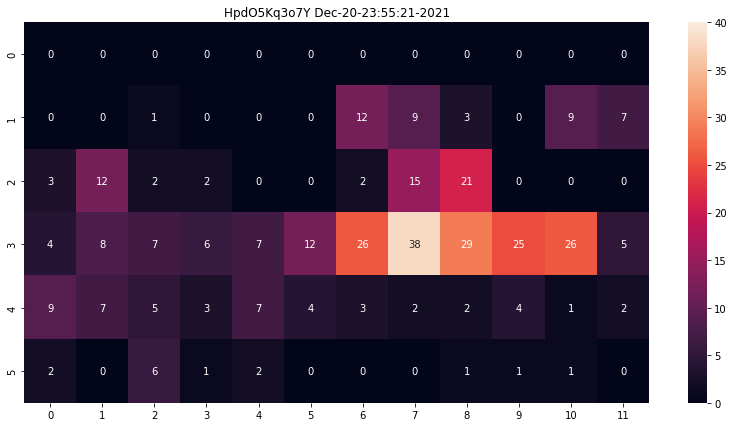

In [73]:
def count_and_add_dataframe_timeseconds(list=None):
    result=create_empty_dataframe()
    for dataframe in list:
        for y in range(0,6):
            for x in range(0,12):
                result.loc[y,x]=result.loc[y,x]+dataframe.loc[y,x]  
    return result
    
dataframes=[]
for timesecond in _timeseconds:
    
    pose_filenames_timeseconds=filter_filenames(list=_pose_filenames,time_seconds=timesecond)
    dataframe=counts_in_dataframe_timeseconds(list=pose_filenames_timeseconds)
    dataframes.append(dataframe)
dataframe=count_and_add_dataframe_timeseconds(list=dataframes)
create_heatmap(dataframe,title=pose_filenames_timeseconds[0].key+' '+str(pose_filenames_timeseconds[0].asctime()),vmax=40)

# Work

In [ ]:
# init
app=_app
_video = app._tab._widgets[0]
single_directory='../data/videos/single'
result_directory='../data/videos/box_bookmarks_6_12'
new=True

## add videos

In [ ]:
_filename = 'https://youtu.be/00s-daBWCZA'
_key=_filename.split('/')[3]
create_single_video_files(app,video_url_id_list=[(_key,_filename)])

In [ ]:
create_all_box_bookmark_files(app=app)

## count

In [ ]:
get_and_save_all_bothboxes_with_data(app=app)

In [ ]:
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_LJ5wabMQ4Vk.json')
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_zTdTIpPiOnQ.json')
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_Cp4RRAEgpeU.json')
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_-Dla8twqg_U.json')
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_6We73xIdHy0.json')
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_G05wmWFDtSo.json')
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_JqUREqYduHw.json')
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_VXzeDtQHTZk.json')
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_VPpiOWbuv8.json')
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_AdUw5RdyZxI.json')
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_HpdO5Kq3o7Y.json')
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_LWMZETF0VQY.json')
get_and_save_selected_boxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video__Oh2hhAnihg.json')


In [ ]:
app=_app2
get_and_save_selected_objectboxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_LJ5wabMQ4Vk.json')
get_and_save_selected_objectboxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_zTdTIpPiOnQ.json')
get_and_save_selected_objectboxes_with_data(app=app, directory='../data/videos/box_bookmarks_6_12',filename='video_Cp4RRAEgpeU.json')

## display videos

In [ ]:
display_all_single_videos(app=app)

## create heatmaps

In [ ]:
_path = '../data/pose_boxes'
_keys = get_keys_boxes_files(_path)
_key=_keys[1]
_timestamps=get_timestamps(path=_path,key=_key)
_keys, _timestamps
# _keys=['6We73xIdHy0',
#  'JqUREqYduHw',
# 'LJ5wabMQ4Vk',
# 'zTdTIpPiOnQ',
# 'vVyBOU9Huvo',
# 'S4AG47F94Ss',
# 'HpdO5Kq3o7Y',
# 'AdUw5RdyZxI',
# '-Dla8twqg_U',
# 'VXzeDtQHTZk',
# 'ns8y0SVcJGA']

In [ ]:
counts_in_dataframe(path='../data/pose_boxes', timestamp=_timestamps[0],key=_key)

In [ ]:
for _key in _keys:
    #print(_key)
    create_heatmap(count_and_add_dataframes(key=_key))

# Work 2

In [ ]:
_files=["https://youtu.be/zTdTIpPiOnQ",
"https://youtu.be/luhiRGPRdAU",
"https://youtu.be/frT95g0j4iY",
"https://youtu.be/9USNTc7Gr4c",
"https://youtu.be/ZEAMi6-jP_s",
"https://youtu.be/AdUw5RdyZxI",
"https://youtu.be/SOKol9vTpwQ",
"https://youtu.be/mNawBricEYw",
"https://youtu.be/tqchfdQQ9L4",
"https://youtu.be/WI4mP963GvE",
"https://youtu.be/WInT7NRq2Ss",
"https://youtu.be/WQz2P-1ua7o",
"https://youtu.be/KIXprc4-ifE",
"https://youtu.be/lsyMF2bmJhM",
"https://youtu.be/Zv1fgmd1pr4",
"https://youtu.be/ISbvot_zEe0"]

_files=["https://youtu.be/oOcqSm7PMBU",
"https://youtu.be/BlywGRXC1B0",
"https://youtu.be/SgUHJMzeXes",
"https://youtu.be/tUPmbZqrC6I",
"https://youtu.be/IjSGWGt6xu8",
"https://youtu.be/tpXPYqpTSH0",
"https://youtu.be/i7PuOxnA_Ks",
"https://youtu.be/P393gTj527k",
"https://youtu.be/Vn2SScdsrnQ",
"https://youtu.be/WjOGhNDX51M",
"https://youtu.be/gQ0vRX86zoo",
"https://youtu.be/4YFHDjig1hc",
"https://youtu.be/hMYIc5ZPJL4",
"https://youtu.be/kxB2ph5D3tc",
"https://youtu.be/jQcotlKaPYY",
"https://youtu.be/0J1Y1MlPCUY",
"https://youtu.be/XnkB8vcua94",
"https://youtu.be/oT4s0SlQ89E",
"https://youtu.be/cvYNX6OONW4",
"https://youtu.be/vq3XWOfFUvY",
"https://youtu.be/xBuVIWTVX9E",
"https://youtu.be/Z6O-6UfpGow",
"https://youtu.be/uHPvvnJdBkk",
"https://youtu.be/jA2H4hPRDQ8",
"https://youtu.be/hP7noGSjLH8",
"https://youtu.be/4Hhsra66kwY",
"https://youtu.be/QBHjPq1iIsI",
"https://youtu.be/Xe64AIg_35s",
"https://youtu.be/w8u_xP5Ri7E",
"https://youtu.be/Eif56OH4Fc0",
"https://youtu.be/vswIKa1zj_s",
"https://youtu.be/W9BhpatGG8I",
"https://youtu.be/nKK6J66RYaw",
"https://youtu.be/XV1q_2Cl6mI",
"https://youtu.be/dvmRgN1FMK0",
"https://youtu.be/9En2186vo5g",
"https://youtu.be/XnkB8vcua94",
"https://youtu.be/v-Q_xOAAD_0",
"https://youtu.be/HmBoxDwR2I8",
"https://youtu.be/kGMOVb0IABs",
"https://youtu.be/eLERLWTpzEM",
"https://youtu.be/sMr2aawoj5A",
"https://youtu.be/CHd0z44hTQc",
"https://youtu.be/qP1y7Tdab7Y",
"https://youtu.be/KVE3aR3hlKM",
"https://youtu.be/qP1y7Tdab7Y",
"https://youtu.be/c4kpeZHcke8",
"https://youtu.be/ly_Jud7WHfo",
"https://youtu.be/UTayfZ5HM9c",
"https://youtu.be/EXvKXsmAmPg",
"https://youtu.be/Vn2SScdsrnQ",
"https://youtu.be/hvmOoI11Dkk",
"https://youtu.be/qP1y7Tdab7Y",
"https://youtu.be/6QQgDyKQTJ0",
"https://youtu.be/DQe_EvBae_I",
"https://youtu.be/f1ydQtKxGf0",
"https://youtu.be/xh48dJYojmE",
"https://youtu.be/jP5QM0l0OYk",
"https://youtu.be/8nPev44Jq4s"]

_files=["h25551--j76C1hX08"]
_files=["https://youtu.be/J-E1rTHvGPo"]
_files=["https://youtu.be/GQVs1EN3Si4"]

app = SimpleApplicationWidget(filename = '_EasyVideoPipeLine_641_481.json')

In [ ]:

for _filename in _files:
    try:
        _key=_filename.split('/')[3]
        create_single_video_files(app,video_url_id_list=[(_key,_filename)])
    except Exception as e:
        print(e,_key)

In [ ]:
def check_all_single_videos(app=None,single_directory='../data/videos/single',index=0):
    for filename in listdir(single_directory):
        try:
            loadVideo(app=app,index=index,filename=single_directory + '/'+ filename)
            print(filename)
        except Exception as e:
            print(single_directory + '/'+ filename + "  :")  
            
check_all_single_videos(app=app)            